In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib; matplotlib.use('Agg')
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors_test as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re
import acceptance_and_angle as aaa

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

point_sources = ['point_sources.fits']

#exposure_time = 4.1e6 #.13 years 47 days
exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
#exposure_time = 4.1e16 #13000 years
#exposure_time = 3.154e10

acceptance_interp = aaa.get_acceptance_interp() #put in the energy in MeV!
angle_interp = aaa.get_angle_interp()


In [3]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        vec = hp.ang2vec(np.pi/2, 0)
        ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)[ipix_disc20]
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        #testbin = np.reshape(test20, (128*3, 1536//3))
        
    return test20

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [4]:


def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str


In [5]:
def subtract(n):
    ##Template for 1 GeV and 10 GeV
    icsa = readfile(filelist[n])
    
    idx1 = get_energy_index(1*1e3, icsa)
    idx10 = get_energy_index(10*1e3, icsa)
    
    array1 = reshape_file(icsa, idx1, inner20 = False)
    array10 = reshape_file(icsa, idx10, inner20 = False)
    
    ##Sum up idx1 and idx 10, make them equal in sum
    sum1 = np.nansum(array1)
    sum10 = np.nansum(array10)
    array10_adjusted = (array10*sum1/sum10)
    subtract110 = np.abs(array1-array10_adjusted)/array1
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(subtract110)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    plt.title(str(filelist[n]))
    
    return

In [6]:


#n = 4 for ICSA, n = 2 for pi0
def psf_smoothing(n, energyidx, inner20psf = False, pointsource = False, use_og = False):
    inner20psf = False
    if pointsource:
        icsa = readfile(point_sources[0])
        data50 = icsa[energyidx-3].data
    else:
        icsa = readfile(filelist[n])
        data50 = reshape_file(icsa, energyidx, inner20 = inner20psf)
    hdu = readfile(filelist[0])


    
    
    #data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
    #print(init_sum)
    energy_here = float(hdu[38].data[energyidx][0])
    sig = np.pi/180*angle_interp(energy_here)
    if use_og:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=np.pi/180/1.508)
    else:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=sig)

    fin_sum = np.sum(data50_convolved[ipix_disc])
    #print(fin_sum)
    

    #data50_convolved = gaussian_filter(data50, sigma=0)
    
    #only get data within 20 degrees
    #hp.mollview(np.log10(data50_convolved), coord = 'G')
    
    
    testbin = data50_convolved[ipix_disc]
    #print(len(testbin))
    
    #print(init_sum)
    #print(fin_sum)
    #print('---------------')


    return np.array(testbin)*init_sum/fin_sum

def psf_smoothing_DM(energyidx, crosssec = 2.2e-26, anal_data = False, mass_dm = 100, use_og = False):
    energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(energyidx)
    
    highe = (energybin+deltae)/1e3
    lowe = (energybin-deltae)/1e3
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    
    #need to make sure the initsum is *only within the inner 20 degrees, same for finsum
    data50 = dmj.get_dNdE(highe, lowe, sigmav = crosssec, analyze_data = anal_data, massx = mass_dm)[1] #photons per cm^2 per sec per str per MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
        
    
    
    energy_here = float(hdu[38].data[energyidx][0])
    sig = np.pi/180*angle_interp(energy_here)
    if use_og:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=np.pi/180/1.508)
    else:
        data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=sig)
    fin_sum = np.sum(data50_convolved[ipix_disc])
    
    #hp.mollview(np.log10(data50_convolved), coord = 'G')
    
    #photons per cm^2 per sec per str per MeV
    
    #print(init_sum)
    #print(fin_sum)
    #print('---------------')
    
    return np.array(data50_convolved[ipix_disc])*init_sum/fin_sum

In [7]:
"""
indexhere = 10
psf_smoothing_DM(indexhere, crosssec = 1e-25)
psf_smoothing_DM(indexhere, crosssec = 1e-25, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(0, indexhere)
psf_smoothing(0, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(2, indexhere)
psf_smoothing(2, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(4, indexhere)
psf_smoothing(4, indexhere, use_og = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
psf_smoothing(np.nan, indexhere, pointsource = True)
psf_smoothing(np.nan, indexhere, pointsource = True, use_og = True)
"""

"\nindexhere = 10\npsf_smoothing_DM(indexhere, crosssec = 1e-25)\npsf_smoothing_DM(indexhere, crosssec = 1e-25, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(0, indexhere)\npsf_smoothing(0, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(2, indexhere)\npsf_smoothing(2, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(4, indexhere)\npsf_smoothing(4, indexhere, use_og = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npsf_smoothing(np.nan, indexhere, pointsource = True)\npsf_smoothing(np.nan, indexhere, pointsource = True, use_og = True)\n"

In [8]:


def poisson_dist(n, energyidx, cross_section =2.2e-26, dm = False, analyze_data = False, dm_mass = 100, egb = False, points = False, counts = 0):   
    '''
    Performs a PSF smoothing of the array, before converting it into photons per pixel
    
    '''
    deltaE = get_deltaE(energyidx)
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_for_poisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    if dm:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, mass_dm = dm_mass)/deltaE
    elif egb:
        convolved_data_init = np.empty(5938) #needs to be the length of the good vals
        convolved_data_init.fill(1) #counts per cm^2 per sec per str
        convolved_data = convolved_data_init*counts #in units of photons per cm^2 per mev per str per sec
    elif points:
        convolved_data = psf_smoothing(n, energyidx, pointsource = True)
    else:
        convolved_data = psf_smoothing(n, energyidx, cross_section) #data in units of photons cm^-2 MeV^-1 str^-1
    #n_gamma = np.array(convolved_data)*deltaE*exposure_time*8500*4*np.pi/196608*.2 #13 years*.85meters^2, units of photons per pixel
    n_gamma = np.array(convolved_data)*deltaE*exposure_time*acceptance_for_poisson/196608 #13 years*.85meters^2, units of photons per pixel

    
    return n_gamma


In [9]:
#deltae_cut = np.copy(deltae[3:])
#egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV


In [10]:
"""
indexhere = 7

poisson_dist(np.nan, indexhere, cross_section =1e-25, dm = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(0, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(2, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(4, indexhere, cross_section =1e-25)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(np.nan, indexhere, cross_section =1e-25, points = True)
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
poisson_dist(np.nan, indexhere, cross_section =1e-25, egb = True, counts = egb_counts[indexhere-3])
"""




"\nindexhere = 7\n\npoisson_dist(np.nan, indexhere, cross_section =1e-25, dm = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(0, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(2, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(4, indexhere, cross_section =1e-25)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(np.nan, indexhere, cross_section =1e-25, points = True)\nprint('~~~~~~~~~~~~~~~~~~~~~~~~~')\npoisson_dist(np.nan, indexhere, cross_section =1e-25, egb = True, counts = egb_counts[indexhere-3])\n"

In [11]:


def get_deltaE(n):
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    bins_in_lin = np.log10(energybins)[n]
    spacing = 0.05691431
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE

def get_image(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(data)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    return

def simulated_data(energyidx, templates):
    
    '''
    Use PSF smoothed data to create a random poisson draw to obtain simulated data
    '''
    
    
    n_gammatot = 0
    for i in range(0, len(templates)):
        n_gammatot += templates[i]
    len_of_rand = len(n_gammatot)
    simdata = np.zeros(len_of_rand)
    randdata = np.random.rand(len_of_rand)
    
    #print(n_gammatot)
    
    for i in range(0, len_of_rand):
        #print(n_gammatot[i])
        if n_gammatot[i]<.01:
            if n_gammatot[i] < randdata[i]:
                simdata[i] = 0
            else:
                simdata[i] = 1
        else:
            simdata[i] = np.random.poisson(lam = n_gammatot[i])
    #print('simdata just 20: ', np.nansum(simdata))
    
    return simdata

def minimize_likelihood(energyidx, cross_sec = 2.2e-26, massdm = 100):
    pi = poisson_dist(2, energyidx)
    ics = poisson_dist(4, energyidx)   
    brem = poisson_dist(0, energyidx)

    darkm = poisson_dist(np.nan, energyidx, cross_section = cross_sec, dm = True, dm_mass = massdm)

    k = simulated_data(energyidx, [pi, ics, brem])#remove DM for accurate
    #print(np.nanmean(lamb))
    #asdfasd
    
    #Need to minimize for lamb < 50 and lamb > 50
    
    bnds = ((0, np.inf), (0, np.inf), (0, np.inf), (1e-30, np.inf))
    result = minimize(likelihood, (1, 1, 1, 1), args = (k, pi, ics, brem, darkm), bounds = bnds)
    min_likelihood = result.x
    chi2 = result.fun
    #print(result)

    return min_likelihood


def likelihood(constants, k, pi, ics, brem, dm):
    """
    Gets the Total Likelihoods from the Gaussian Regime and the Poisson Regime
    Once each has been calculated, multiplies values together for final likelihood
    """
    
    likelihood_poiss = likelihood_poisson(constants, k, pi, ics, brem, dm)
    #print('likelihood: {}'.format(likelihood_poiss)) 
    return likelihood_poiss

def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list

def likelihood_gaussian(constants, lamb, pi, ics):
    sigma = np.sqrt(constants[0]*pi+constants[1]*ics)
    mu = lamb
    rng = 0.5
    
    #flatten arrays
    sigma_flat = sigma.flatten()
    mu_flat = mu.flatten()
    length_flattened = len(mu_flat)
    #get arrays in sigma, mu tuple format
    ms_tuples = list(merge(mu_flat, sigma_flat))
    ms = np.array(ms_tuples, dtype = 'f,f')
    lower_bound_arr = mu_flat - rng
    upper_bound_arr = mu_flat + rng
    
    args = np.concatenate((np.full((length_flattened, 1), prob_func), lower_bound_arr.reshape((length_flattened, 1)), upper_bound_arr.reshape((length_flattened, 1)), ms.reshape((length_flattened, 1))), axis = 1)
    
    #log likelihood
    prob = list(starmap(lambda a, b, c, d: quad(a, b, c, d)[0], args))

    #reshape for testing
    l = np.sum(np.log(prob))
    likely = -2*l
    
    return likely
    
def prob_func(x, mu, sigma):
    probdens = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-sigma**2)/sigma)**2)
    return probdens

#def likelihood_poisson(a0):
def likelihood_poisson(a0, a1, a2, a3, a4):
#def likelihood_poisson(constants, ktest, pitest, icstest, bremtest, dmtest):
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    return np.asarray(data50)*exposure_time*acceptance_forpoisson*delt #try to get in terms of counts per bin
    
    
def get_normalizations_spectrum(deltaE, cross_sec = 2.2e-26, dm_mass = 100):
    
    range_templates = [2, 4, 0] #pi, ics, brem
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 1/196608 #i think this should maybe still be total bins in whole image pre-20?
    
    acceptances = []
    for energyidxhere in range(3, len(energies)):
        energyidx = energyidxhere
        hdu = readfile(filelist[0])
        energy_here = float(hdu[38].data[energyidx][0])
        acceptance_forpoisson = acceptance_interp(energy_here) #in cm^2*str
        acceptances.append(acceptance_forpoisson)
    

    for n in range_templates:
        temp = []
        for index in range(3, len(energies)):
            temp.append(np.nansum(get_curves(n, index))) #units of photons per bin
        templates.append(np.asarray(temp)*deltaomega) #gets counts per bin

    
    #dark matter template
    
    '''
    
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)*exposure_time) #13 years * .85 m^2 * .2, return in photons/str
    dm_templates_tot.append(np.asarray(dm_temp)*deltaomega) #photons per pixel?
    '''
    
    
    #EGB template
    egb_templates = np.array(get_all_egb(energies, deltaE)) #units of counts per cm^2 per sec per str
    egb_temp_fin = egb_templates*acceptances*exposure_time*deltaomega #counts per bin
    
    #Point Source Template
    point_source_arr = []
    for index in range(3, len(energies)):
        smaller_index = int(index - 3)
        point_source_arr.append(np.nansum(get_curves_pointsource(index, smaller_index, inner20psf = True))*deltaomega) #photons per pixel
        
    print('yay!')
        

    return range_templates, energies, [np.array(templates[0]), np.array(templates[1]), np.array(templates[2]), np.array(egb_temp_fin), np.array(point_source_arr)] #counts per pixel
    #return range_templates, np.asarray(dm_temp)*deltaomega
    
def get_curves_pointsource(energyidx, smallindex, inner20psf = True):
    pointsourcedata = readfile(point_sources[0])[smallindex].data
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
    test20 = np.copy(pointsourcedata)[ipix_disc20]
    
    delt = get_deltaE(energyidx)
    
    deltaE = get_deltaE(energyidx)
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    
    return np.asarray(test20)*exposure_time*acceptance_forpoisson*delt #13 years * .85 m^2 * .2, return in photons /bin
    
    
def get_normalized(energyidx, normals, template_val, energies):
    '''
    Normalizes the ROI based on the shape the spectrums should have
    
    
    Do not need to use this, as long as you stay consistent across all Fermi data
    for the exposure time and collecting area
    
    '''
    
    poisson_pi = poisson_dist(template_val, int(energyidx)) #units of photons per pixel
    init_sum_pi = np.nansum(poisson_pi)
    #print(np.nansum(init_sum_pi))
    if template_val == 2:
        normval = 0
    if template_val == 4:
        normval = 1
    if template_val == 0:
        normval = 2
    print('normval for pi at 0: {}'.format(normals[normval][energyidx])) 
    print('delta E at 0: {}'.format(get_deltaE(energyidx)))
    normal_pi = normals[normval][energyidx]*get_deltaE(energyidx)
    pitest = poisson_pi*normal_pi/init_sum_pi
    print('normalization: {}'.format(np.nansum(pitest)))
    #print(np.nansum(pitest))
    
    #print('----------------------')
    
    return pitest
    

In [12]:


def get_darksusy_counts():
    x = np.loadtxt('yield_DS_keith100.dat', dtype=str).T
    energies = x[1].astype(np.float)*1e3
    yieldperann = x[2].astype(np.float)/1e3 #convert from per GeV to per MeV
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    
    counts = []
    delta = []
    for n in range(0, 38):
        
        bins_in_lin = energybins[n]
        deltae = get_deltaE(n)
    
        highe = (bins_in_lin+deltae)
        lowe = (bins_in_lin-deltae)
        
        good_energies = np.where((energies <=highe) & (energies >= lowe))
        
        final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])

        counts.append(final_integral)
        delta.append(deltae)
    return np.array(counts), np.array(delta)



def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str




In [13]:
importlib.reload(dmj)

#gets darksusy counts for a specific dark matter mass
counts, deltae = get_darksusy_counts()
#be sure to change the dm mass
temps, energies, normals = get_normalizations_spectrum(deltae, cross_sec = 2.2e-26)


yay!


In [14]:
acceptances = []
cut_energy = energies[3:]
for energyidxhere in range(0, len(cut_energy)):
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson)

In [15]:
'''
deltae_cut = np.copy(deltae[3:])
units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]
fntsz = 10

for i in range(0, len(normals)):
    plt.scatter(cut_energy, normals[i]/units*cut_energy**2, label = str(i))


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7, 1e2)
plt.show()
plt.close()
#plt.ylim(1e-8, 3e1)
#plt.legend()
'''


"\ndeltae_cut = np.copy(deltae[3:])\nunits = deltae_cut*exposure_time/196608*acceptances\ncut_energy = energies[3:]\nfntsz = 10\n\nfor i in range(0, len(normals)):\n    plt.scatter(cut_energy, normals[i]/units*cut_energy**2, label = str(i))\n\n\nplt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)\nplt.xlabel('MeV', fontsize = fntsz)\nplt.legend(fontsize = 15)\nplt.yscale('log')\nplt.xscale('log')\nplt.ylim(1e-7, 1e2)\nplt.show()\nplt.close()\n#plt.ylim(1e-8, 3e1)\n#plt.legend()\n"

In [16]:
#code that returns the log-likelihood at a specific point. cube is first parameter, everything else are random parameters
#that are not part of the fitting cube
def likelihood_poisson_multinest(cube, pitest, icstest, bremtest, egbtest, pointstest, darkmtest, ktest):
    
    a0 = 10**cube[0]
    a1 = 10**cube[1]
    a2 = 10**cube[2]
    a3 = 10**cube[3]
    lamb = a0*pitest+a1*icstest+a2*bremtest+egbtest+a3*pointstest+darkmtest
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

#pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest
def likelihood_poisson_multinest2(cube, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest):
    a0 = cube[0]
    a1 = cube[1]
    a2 = cube[2]
    a3 = cube[3]
    
    lamb = a0 * pitest + a1 * icstest + a2 * bremtest + egbtest + a3 * pointstest + darkmtest

    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return -2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

#finds the log likelihood based on the constants that pymultinest have found. The constants have already
#been moved from logspace to linearspace
#I do this for every energy bin, and come out with one big log likelihood value for some value of sigmav.
#They are *summed* over all energy bins.I have 35 log likelihoods, which I then add up, for my final answer.
#constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest
def likelihood_poisson_forsigmav(constants, piflux, icsflux, bremflux, egbflux, pointsflux, ktesthere,
                                 darkmatter):
    #Constants are my consants for pi, ics, brem, and point sources. the constant in front of egb is 1.
    #The 'constant' in front of the dark matter is already incorporated by changing sigmav
    #This is my value of lambda
    lambd = constants[0]*piflux+constants[1]*icsflux+constants[2]*bremflux+egbflux+constants[3]*pointsflux+darkmatter

    
    #my value of k (ktest) is the poisson drawn values from sum of all the templates except dm
    fprob = -scipy.special.gammaln(ktesthere+1)+ktesthere*np.log(lambd)-lambd #log likelihood of poisson
    #scipy.special.gammaln is for the log of a factorial
    return -2*np.nansum(fprob) #the sum of all the log likelihoods for each spatial point. 

##This is the prior function, it is flat in linear space, from a minimum value specified by the first number, 
#to a maximum number specified by the first number + the second number. 
#The variables were called a/b/c/phi0/phi1/norm in this code.
#You need to define a prior for every parameter you send

cube_limits = [(-2, 4), (-2, 4), (-2, 4), (-2, 4)]

def prior(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*cube_limits[0][1] + cube_limits[0][0])
    cube[1] = (cube[1]*cube_limits[1][1] + cube_limits[1][0])
    cube[2] = (cube[2]*cube_limits[2][1] + cube_limits[2][0])
    cube[3] = (cube[3]*cube_limits[3][1] + cube_limits[3][0])
    return cube

##This is the loglikelihood function for multinest – it sends the cube,
#and then a bunch of different arrays that were used in fitting, but were constant, to the pymultinest code
def loglikelihood_formulti(cube, ndim, nparms):
    return likelihood_poisson_multinest(cube, pitest, icstest, bremtest, egbtest, pointstest, darkmtest, ktest)


In [17]:
def get_dm_array(cross_section = 2.2e-26, dm_mass = 100):
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_section, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)/deltae) 
    dm_templates_tot.append(np.asarray(dm_temp)) #photons per s per cm^2 per MeV per str
    return dm_templates_tot




In [18]:
#get all ktests

ktest_array = []

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
deltae_cut = np.copy(deltae[3:])

egb_counts = get_all_egb(energies, deltae)/deltae_cut
counting = 0


for energyidx in range(3, len(energies)):
    print(energyidx)
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))
    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])


    #Point Sources
    pointstest = poisson_dist(np.nan, energyidx, points = True) 


    #gotta add egbtest to the ktest

    #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
    ktest1 = simulated_data(int(energyidx), [pitest, icstest, bremtest, egbtest, pointstest])
    ktest_array.append(ktest1)
    
    counting += 1
        

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [19]:


#now need to get the values from the folder, and then calculate the loglikelihood with the dark matter
test_crosses_init = np.logspace(np.log10(1e-25), np.log10(1e-29), num = 6)
test_crosses = np.concatenate((test_crosses_init, [0]))
print(test_crosses)
#likelihood_collection = [0 for x in range(len(test_crosses))]
total_likelihood = 0

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])
    
#probably do for every value of sigmav:
counting_crossec = 0
importlib.reload(dmj)

deltaE = get_deltaE(energyidx)
hdu = readfile(filelist[0])
energy_here = float(hdu[38].data[energyidx][0])
acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2

units = deltae_cut*exposure_time/196608*acceptance_forpoisson


likelihood_collection = []

for test_cross_here in test_crosses:
    #test_cross_here = 1e-26
    print('--------------------------')
    print('CROSS SECTION:')
    test_cross = float("%.5g" % test_cross_here)
    print(test_cross)
    print('--------------------------')
    #getting errors and stuff for the dark matter stuff
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    #cross_sec normalized to 2.2e-26
    points = []
    errors = []
    values = []
    fluxes = []
    deltae_cut = np.copy(deltae[3:])


    #EGB getting now, first get all the counts at each energy bin
    egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV

    ##These are the names of the parameters we are fitting.
    parameters = ['a0', 'a1', 'a2', 'a3']
    #parameters = ['a0', 'a1', 'a2']
    folder = './pymultinest_chains/cross_sections_fermi2/'
    livepoints = 400

    '''Check if directory exists, if not, create it'''
    import os

    # You should change 'test' to your preferred folder.
    MYDIR1 = (folder + "cross_sec" + str(test_cross))
    folder_name = "cross_sec" + str(test_cross)
    CHECK_FOLDER = os.path.isdir(MYDIR1)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR1)
        print("created folder : ", MYDIR1)

    else:
        print(MYDIR1, "folder already exists.")
    
    #getting the constants in front of the poission dist. arrays
    temp_likelihood = 0
    counting = 0
    for energyidx in range(3, len(energies)):
        #energyidx = 7
        counting = energyidx-3
        #counting = 18-3
        # You should change 'test' to your preferred folder.
        MYDIR = (MYDIR1 + "/chain" + str(energyidx))
        CHECK_FOLDER = os.path.isdir(MYDIR)

        # If folder doesn't exist, then create it.
        if not CHECK_FOLDER:
            os.makedirs(MYDIR)
            print("created folder : ", MYDIR)

        else:
            print(MYDIR, "folder already exists.")
        print(energyidx, energies[energyidx])
        
        #photons per pixel
        pitest = poisson_dist(2, int(energyidx), cross_section = test_cross)
        icstest = poisson_dist(4, int(energyidx), cross_section = test_cross)
        bremtest = poisson_dist(0, int(energyidx), cross_section = test_cross)
        
        #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
        egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting], cross_section = test_cross)
        
        #Dark matter
        importlib.reload(dmj) 
        darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

        darkmtest[np.isnan(darkmtest)] = 0
        
        
        #Point Sources
        pointstest = poisson_dist(np.nan, energyidx, points = True, cross_section = test_cross) 

        #gotta add egbtest to the ktest

        #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
        ktest = ktest_array[counting]
        
        print(np.sum(ktest))
        print(np.sum(pitest+icstest+bremtest+egbtest+pointstest+darkmtest))

        
        
        finals = pymultinest.run(loglikelihood_formulti, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)
        json.dump(parameters, open(MYDIR+'/' + str(energyidx) + 'params' +'.json', 'w'))
        counting += 1
        
        #now need to find the likelihood for this best fit value
        
        #create the .data file
        !python3 ./pymultinest_chains/multinest_marginals.py ./{MYDIR1}/chain{energyidx}/{energyidx}
        #Open the file
        path_to_this_file = MYDIR + '/' + str(energyidx) + 'stats.json'
        f = open(path_to_this_file)
        filehere = json.load(f)
        print(path_to_this_file)
        constants = []
        testpoints0 = (10**(filehere['marginals'][0]['median'])) #pitest
        testpoints1 = (10**(filehere['marginals'][1]['median'])) #icstest
        testpoints2 = (10**(filehere['marginals'][2]['median'])) #bremtest
        testpoints3 = (10**(filehere['marginals'][3]['median'])) #pointsources
        print('---------------')
        constants=[testpoints0, testpoints1, testpoints2, testpoints3]
        print(likelihood_poisson_multinest2([testpoints0, testpoints1, testpoints2, testpoints3], pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest))
        print('---------------')
        lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+egbtest+constants[3]*pointstest+darkmtest
        
        
        likehere = likelihood_poisson_forsigmav(constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest)
        temp_likelihood += likehere
        #temp_likelihood += -2*filehere["modes"][0]["strictly local log-evidence"]
        print(likehere)
    print('------------')
    likelihood_collection.append(temp_likelihood)
    counting_crossec +=1
print('----------')


#break

print('------------------')

[1.00000000e-25 1.58489319e-26 2.51188643e-27 3.98107171e-28
 6.30957344e-29 1.00000000e-29 0.00000000e+00]
--------------------------
CROSS SECTION:
1e-25
--------------------------
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain3
3 109.7629710930695
sigmav: 1e-25
37009152.0
37117347.47236985
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain3/3"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain3/3.txt
  marginal likelihood:
    ln Z = -67711.5 +- 0.0
  parameters:
    a0             -0.218 +- 0.041
    a1             -0.00266 +- 0.00033
    a2             0.0615 +- 0.0085
    a3             0.00090 +- 0.00037
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain3/3stats.json
---------------
67681.93668809641
---------------
67681.93668809641
created folder :  ./pymultinest_chains/

  marginal likelihood:
    ln Z = -36296.6 +- 0.2
  parameters:
    a0             -0.392 +- 0.099
    a1             -0.259 +- 0.017
    a2             0.327 +- 0.031
    a3             0.0101 +- 0.0093
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain14/14stats.json
---------------
36277.54178041034
---------------
36277.54178041034
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain15
15 2549.1726673347453
sigmav: 1e-25
99841.0
113639.30521267914
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain15/15"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain15/15.txt
  marginal likelihood:
    ln Z = -32662.0 +- 0.0
  parameters:
    a0             -0.31 +- 0.10
    a1             -0.470 +- 0.036
    a2             0.362 +- 0.040
    a3             0.002 +- 0.011
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain15/15stat

./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain26/26stats.json
---------------
2408.1063560269004
---------------
2408.1063560269004
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain27
27 59202.85523591168
sigmav: 1e-25
191.0
184.99416446688178
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain27/27"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain27/27.txt
  marginal likelihood:
    ln Z = -1614.9 +- 0.0
  parameters:
    a0             -0.80 +- 0.78
    a1             -0.19 +- 0.43
    a2             -0.70 +- 0.96
    a3             0.60 +- 0.13
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain27/27stats.json
---------------
1610.132760806658
---------------
1610.132760806658
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-25/chain28
28 76943.38154619717
sigmav: 1e-25
126.0
119.9148824726549
model "././pymultine

./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain3/3stats.json
---------------
67495.76965635103
---------------
67495.76965635103
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain4
4 142.65416981671697
sigmav: 1.5849e-26
23902714.0
23918432.082848784
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain4/4"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain4/4.txt
  marginal likelihood:
    ln Z = -64897.9 +- 0.1
  parameters:
    a0             0.006 +- 0.020
    a1             -0.00087 +- 0.00041
    a2             -0.003 +- 0.011
    a3             -0.00112 +- 0.00052
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain4/4stats.json
---------------
64868.63229630634
---------------
64868.63229630634
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain5
5 185.40143331981702
sigmav: 1.584

sigmav: 1.5849e-26
99841.0
102605.55920502241
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain15/15"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain15/15.txt
  marginal likelihood:
    ln Z = -31929.0 +- 0.6
  parameters:
    a0             -0.010 +- 0.052
    a1             -0.066 +- 0.013
    a2             0.055 +- 0.082
    a3             -0.008 +- 0.013
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain15/15stats.json
---------------
31910.917263798652
---------------
31910.917263798652
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain16
16 3313.049081641206
sigmav: 1.5849e-26
55607.0
57081.59033852247
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain16/16"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain16/16.txt
  marginal likelihood:
    ln Z = -28596.7 

./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain26/26stats.json
---------------
2408.418804781557
---------------
2408.418804781557
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain27
27 59202.85523591168
sigmav: 1.5849e-26
191.0
182.62531215002605
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain27/27"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain27/27.txt
  marginal likelihood:
    ln Z = -1615.0 +- 0.1
  parameters:
    a0             -0.82 +- 0.80
    a1             -0.15 +- 0.43
    a2             -0.73 +- 0.86
    a3             0.60 +- 0.12
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain27/27stats.json
---------------
1609.7895396038598
---------------
1609.7895396038598
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1.5849e-26/chain28
28 76943.38154619717
sigmav: 1.5849e-26
126.

sigmav: 2.5119e-27
37009152.0
37013176.08755066
model "././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain3/3"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain3/3.txt
  marginal likelihood:
    ln Z = -67525.2 +- 0.1
  parameters:
    a0             -0.021 +- 0.027
    a1             0.00044 +- 0.00032
    a2             0.006 +- 0.010
    a3             0.00063 +- 0.00037
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain3/3stats.json
---------------
67495.56654446563
---------------
67495.56654446563
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain4
4 142.65416981671697
sigmav: 2.5119e-27
23902714.0
23904217.809406117
model "././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain4/4"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain4/4.txt
  marginal likelihood:
    ln Z = -64883.7 +

  marginal likelihood:
    ln Z = -35459.3 +- 0.0
  parameters:
    a0             0.001 +- 0.040
    a1             0.0176 +- 0.0089
    a2             -0.030 +- 0.070
    a3             -0.0038 +- 0.0099
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain14/14stats.json
---------------
35439.16444707496
---------------
35439.16444707496
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain15
15 2549.1726673347453
sigmav: 2.5119e-27
99841.0
100856.81975001036
model "././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain15/15"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain15/15.txt
  marginal likelihood:
    ln Z = -31910.2 +- 0.1
  parameters:
    a0             0.026 +- 0.048
    a1             -0.027 +- 0.012
    a2             -0.028 +- 0.098
    a3             -0.009 +- 0.013
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2

sigmav: 2.5119e-27
323.0
284.0173005054007
model "././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain26/26"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain26/26.txt
  marginal likelihood:
    ln Z = -2414.2 +- 0.0
  parameters:
    a0             0.27 +- 0.78
    a1             -1.12 +- 0.65
    a2             0.4 +- 1.2
    a3             0.33 +- 0.26
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain26/26stats.json
---------------
2409.68950848145
---------------
2409.68950848145
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain27
27 59202.85523591168
sigmav: 2.5119e-27
191.0
182.24987252084588
model "././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain27/27"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain27/27.txt
  marginal likelihood:
    ln Z = -1615.2 +- 0.1
  parameters:
 

./pymultinest_chains/cross_sections_fermi2/cross_sec2.5119e-27/chain37/37stats.json
---------------
37.69651774477975
---------------
37.69651774477975
------------
--------------------------
CROSS SECTION:
3.9811e-28
--------------------------
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain3
3 109.7629710930695
sigmav: 3.9811e-28
37009152.0
37010917.38693471
model "././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain3/3"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain3/3.txt
  marginal likelihood:
    ln Z = -67525.1 +- 0.5
  parameters:
    a0             -0.017 +- 0.026
    a1             0.00050 +- 0.00030
    a2             0.0051 +- 0.0097
    a3             0.00062 +- 0.00035
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain3/3stats.json
---------------


sigmav: 3.9811e-28
178931.0
178840.75922082705
model "././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain14/14"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain14/14.txt
  marginal likelihood:
    ln Z = -35458.3 +- 0.1
  parameters:
    a0             0.007 +- 0.038
    a1             0.0217 +- 0.0086
    a2             -0.043 +- 0.070
    a3             -0.0045 +- 0.0096
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain14/14stats.json
---------------
35438.20003523805
---------------
35438.20003523805
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain15
15 2549.1726673347453
sigmav: 3.9811e-28
99841.0
100579.66294886093
model "././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain15/15"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain15/15.txt
  marginal likelihood:
    ln Z = -3190

./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain25/25stats.json
---------------
2985.089583646384
---------------
2985.089583646384
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain26
26 45552.69079225364
sigmav: 3.9811e-28
323.0
283.78752893967294
model "././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain26/26"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain26/26.txt
  marginal likelihood:
    ln Z = -2414.1 +- 0.1
  parameters:
    a0             0.24 +- 0.84
    a1             -1.02 +- 0.61
    a2             0.6 +- 1.1
    a3             0.32 +- 0.28
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain26/26stats.json
---------------
2408.949507417741
---------------
2408.949507417741
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain27
27 59202.85523591168
sigmav: 3.9811e-28
191.0
182.

    a3             -1.03 +- 0.67
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec3.9811e-28/chain37/37stats.json
---------------
37.89442926043444
---------------
37.89442926043444
------------
--------------------------
CROSS SECTION:
6.3096e-29
--------------------------
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain3
3 109.7629710930695
sigmav: 6.3096e-29
37009152.0
37010559.406090766
model "././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain3/3"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain3/3.txt
  marginal likelihood:
    ln Z = -67526.0 +- 0.1
  parameters:
    a0             -0.015 +- 0.028
    a1             0.00052 +- 0.00032
    a2             0.005 +- 0.011
    a3             0.00063 +- 0.00034
creating marginal plot ...
./pymultinest_chains/cross_sections_fer

./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain13/13stats.json
---------------
38884.66845329205
---------------
38884.66845329205
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain14
14 1961.420168477385
sigmav: 6.3096e-29
178931.0
178779.31204759819
model "././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain14/14"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain14/14.txt
  marginal likelihood:
    ln Z = -35458.2 +- 0.0
  parameters:
    a0             0.009 +- 0.036
    a1             0.0221 +- 0.0081
    a2             -0.045 +- 0.067
    a3             -0.0048 +- 0.0091
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain14/14stats.json
---------------
35438.021087479196
---------------
35438.021087479196
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain15
15 2549.1726673347453
sigmav:

429.0
443.66055801604955
model "././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain25/25"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain25/25.txt
  marginal likelihood:
    ln Z = -2990.5 +- 0.0
  parameters:
    a0             0.26 +- 0.23
    a1             -0.25 +- 0.50
    a2             -0.60 +- 0.98
    a3             -0.97 +- 0.67
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain25/25stats.json
---------------
2984.9552525440604
---------------
2984.9552525440604
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain26
26 45552.69079225364
sigmav: 6.3096e-29
323.0
283.7511125069522
model "././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain26/26"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain26/26.txt
  marginal likelihood:
    ln Z = -2414.2 +- 0.1
  parameters:
    a0      

./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain36/36stats.json
---------------
46.627493203337615
---------------
46.627493203337615
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain37
37 814008.272175696
sigmav: 6.3096e-29
2.0
1.988439777418364
model "././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain37/37"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain37/37.txt
  marginal likelihood:
    ln Z = -39.8 +- 0.0
  parameters:
    a0             -0.35 +- 0.98
    a1             0.26 +- 0.92
    a2             -0.1 +- 1.3
    a3             -1.07 +- 0.70
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec6.3096e-29/chain37/37stats.json
---------------
37.89986057339205
---------------
37.89986057339205
------------
--------------------------
CROSS SECTION:
1e-29
--------------------------
created folder :  ./pymultinest_chains/cross_sections

  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain13/13.txt
  marginal likelihood:
    ln Z = -38905.3 +- 0.5
  parameters:
    a0             -0.014 +- 0.033
    a1             0.0017 +- 0.0066
    a2             0.021 +- 0.045
    a3             -0.0005 +- 0.0073
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain13/13stats.json
---------------
38884.735050563046
---------------
38884.735050563046
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain14
14 1961.420168477385
sigmav: 1e-29
178931.0
178769.5733527682
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain14/14"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain14/14.txt
  marginal likelihood:
    ln Z = -35458.0 +- 0.1
  parameters:
    a0             0.009 +- 0.040
    a1             0.0225 +- 0.0084
    a2             -0.046 +- 0.073
    a3             -0.005 +- 0

sigmav: 1e-29
429.0
443.64321753615934
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain25/25"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain25/25.txt
  marginal likelihood:
    ln Z = -2990.4 +- 0.3
  parameters:
    a0             0.27 +- 0.18
    a1             -0.30 +- 0.50
    a2             -0.51 +- 0.95
    a3             -0.86 +- 0.67
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain25/25stats.json
---------------
2985.2762845724005
---------------
2985.2762845724005
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain26
26 45552.69079225364
sigmav: 1e-29
323.0
283.74534090662587
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain26/26"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain26/26.txt
  marginal likelihood:
    ln Z = -2414.2 +- 0.1
  parameters:
    a0             0.30 +- 0.69


sigmav: 1e-29
2.0
1.988439777418364
model "././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain37/37"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain37/37.txt
  marginal likelihood:
    ln Z = -39.8 +- 0.0
  parameters:
    a0             -0.45 +- 0.91
    a1             0.23 +- 0.96
    a2             0.0 +- 1.3
    a3             -1.03 +- 0.67
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec1e-29/chain37/37stats.json
---------------
38.01497006034687
---------------
38.01497006034687
------------
--------------------------
CROSS SECTION:
0.0
--------------------------
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec0.0
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain3
3 109.7629710930695
sigmav: 0.0
37009152.0
37010491.984552175
model "././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain3/3"
  analysing data from ././pymultinest_chains/cr

sigmav: 0.0
178931.0
178767.73918544297
model "././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain14/14"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain14/14.txt
  marginal likelihood:
    ln Z = -35458.1 +- 0.0
  parameters:
    a0             0.010 +- 0.038
    a1             0.0217 +- 0.0087
    a2             -0.048 +- 0.070
    a3             -0.0047 +- 0.0095
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain14/14stats.json
---------------
35438.12101234221
---------------
35438.12101234221
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain15
15 2549.1726673347453
sigmav: 0.0
99841.0
100527.46339540218
model "././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain15/15"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain15/15.txt
  marginal likelihood:
    ln Z = -31909.7 +- 0.1
  parameters:
    a0             0.033 +- 0.0

sigmav: 0.0
323.0
283.7442538943601
model "././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain26/26"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain26/26.txt
  marginal likelihood:
    ln Z = -2414.0 +- 0.1
  parameters:
    a0             0.22 +- 0.80
    a1             -1.06 +- 0.61
    a2             0.6 +- 1.1
    a3             0.35 +- 0.24
creating marginal plot ...
./pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain26/26stats.json
---------------
2409.3981253286156
---------------
2409.3981253286156
created folder :  ./pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain27
27 59202.85523591168
sigmav: 0.0
191.0
182.17916248609038
model "././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain27/27"
  analysing data from ././pymultinest_chains/cross_sections_fermi2/cross_sec0.0/chain27/27.txt
  marginal likelihood:
    ln Z = -1615.2 +- 0.0
  parameters:
    a0             -0.75 +- 0.77
    a1             -

In [20]:
32093.000149843658-32075.89737503821

17.102774805447552

In [ ]:
print(np.abs(np.array(likelihood_collection[0:10])-likelihood_collection[-1]))
print(energies[-1])


In [20]:

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.abs(np.array(likelihood_collection[0:10])-likelihood_collection[-1]), s = 50)
plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)
plt.xlim(1e-30, 1e-25)
plt.ylim(1e-1, 1e6)
plt.hlines(4, 1e-30, 1e-23)
plt.show()
plt.savefig('loglikelihood_zoomtest1.pdf')

#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))


In [29]:
true_values = ktest_array[12]



energyidx = 12+3
counting = 12

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]

egb_counts = get_all_egb(energies, deltae)/deltae_cut

#photons per pixel
pitest = poisson_dist(2, int(energyidx), cross_section = test_cross)
icstest = poisson_dist(4, int(energyidx), cross_section = test_cross)
bremtest = poisson_dist(0, int(energyidx), cross_section = test_cross)


#EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting], cross_section = test_cross)

importlib.reload(dmj) 
darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

darkmtest[np.isnan(darkmtest)] = 0

#Point Sources
pointstest = poisson_dist(np.nan, energyidx, points = True, cross_section = test_cross) 

vals_w_dm = np.copy(lamb)

print(test_cross)


sigmav: 0.0
0.0


In [30]:
energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
bins_in_lin = np.log10(energybin)
deltae_here = get_deltaE(energyidx)
    
highe = (energybin+deltae_here)/1e3
lowe = (energybin-deltae_here)/1e3
    
hdu = readfile(filelist[0])
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])
    
degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    
#need to make sure the initsum is *only within the inner 20 degrees, same for finsum
data50 = dmj.get_dNdE(highe, lowe, sigmav = test_cross, analyze_data = False, massx = 100)[1] #photons per cm^2 per sec per str per MeV
    
#get_where_within_20deg
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])
vec = hp.ang2vec(np.pi/2, 0)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)

ipix_disc_big = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(360), inclusive = False)

data50[ipix_disc_big] = np.nan

data501 = np.copy(data50)
data502 = np.copy(data50)

data501[ipix_disc] = true_values
data502[ipix_disc] = vals_w_dm


    

sigmav: 0.0


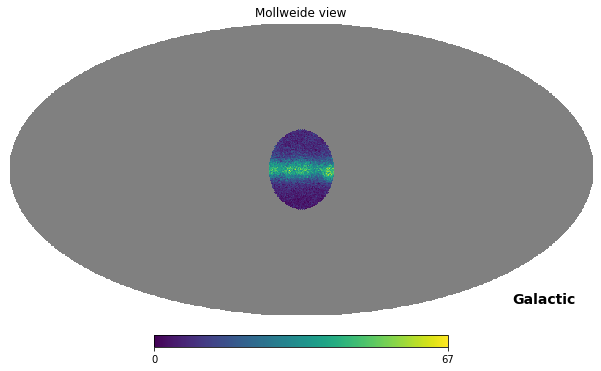

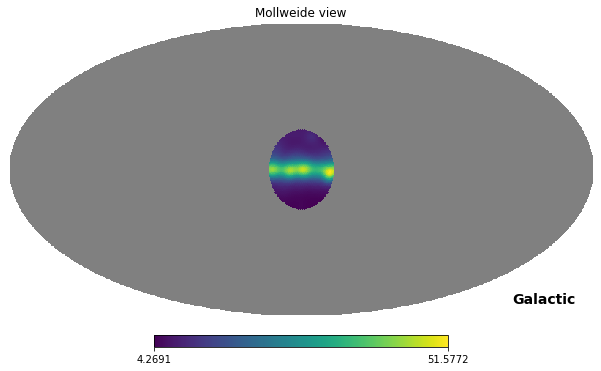

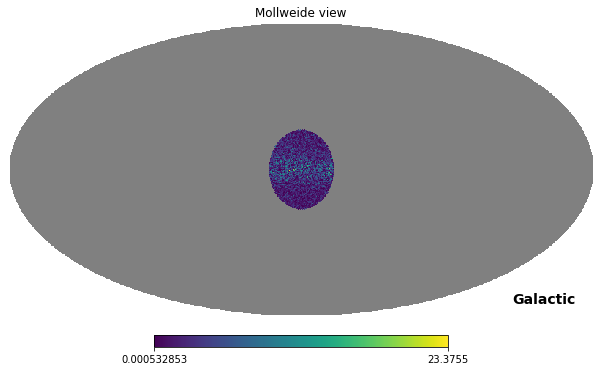

In [31]:
hp.mollview((data501), coord = 'G')

hp.mollview((data502), coord = 'G')

hp.mollview((np.abs(data501-data502)), coord = 'G')

In [ ]:
ipix_disc1 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(1), inclusive = False)
print(ipix_disc1)
print(data50[99071])
print(np.where(ipix_disc == 99071))

print(pitest[3053])
print(bremtest[3053])
print(egbtest[3053])
print(pointstest[3053])
print(icstest[3053])
print(darkmtest[3053])





In [ ]:
print(data501)
print(data502)

plt.hist(np.abs(data501-data502), bins = 20)


In [ ]:
test_crosses_init = np.logspace(np.log10(1e-22), np.log10(1e-27), num = 20)
test_crosses = np.concatenate((test_crosses_init, [0]))
test_cross = test_crosses_init[0]
counting = 0
for energyidx in range(3, len(energies)):        
    #photons per pixel
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))


    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])

    importlib.reload(dmj) 
    darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = test_cross, analyze_data = False)

    darkmtest[np.isnan(darkmtest)] = 0

    #Point Sources
    pointstest = poisson_dist(np.nan, energyidx, points = True) 


    #gotta add egbtest to the ktest

    #ktest = pitest+icstest+bremtest+darkmtest+egbtest+pointstest+darkmtest
    ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest, egbtest, pointstest, darkmtest])
    tot = pitest+icstest+bremtest+egbtest+pointstest+darkmtest
    
    plt.hist(ktest, color = 'red')
    plt.hist(tot, color = 'blue')
    counting += 1
    sdfasd
    

In [ ]:
print(np.array(likelihood_collection[0:10]-likelihood_collection[-1]))
print(likelihood_collection)

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.abs(np.array(likelihood_collection[0:10]-likelihood_collection[-1])), s = 50)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)
plt.xlim(1e-27, 1e-20)
plt.ylim(0, 1e2)
#plt.savefig('loglikelihood_zoom.pdf')

#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))


In [ ]:
## Trying to get the log likelihoods another way
import os

test_crosses_init = np.logspace(np.log10(1e-22), np.log10(1e-27), num = 10)
test_crosses = np.concatenate((test_crosses_init, [0]))

likelihoods_test2 = []

for test_cross in test_crosses:
    # You should change 'test' to your preferred folder.
    MYDIR1 = (folder + "cross_sec" + str(test_cross))
    folder_name = "cross_sec" + str(test_cross)
    CHECK_FOLDER = os.path.isdir(MYDIR1)
    templike = 0
    for energyidx in range(3, len(energies)):
        MYDIR = (MYDIR1 + "/chain" + str(energyidx))
        path_to_this_file = MYDIR + '/' + str(energyidx) + 'stats.json'
        f = open(path_to_this_file)
        filehere = json.load(f)
        likeli = -filehere['modes'][0]['strictly local log-evidence']
        templike += likeli
    likelihoods_test2.append(templike)


In [ ]:
print(likelihoods_test2[0:10])
print(likelihoods_test2[-1])
print(np.array(likelihoods_test2[0:10])-likelihoods_test2[-1])


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20

plt.scatter(test_crosses[0:10], np.array(np.array(likelihoods_test2[0:10])-float(likelihoods_test2[-1])), s = 50)
plt.scatter(test_crosses[0:10], np.array(np.array(likelihood_collection[0:10])-float(likelihood_collection[-1])), s = 50, color = 'red')

#plt.yscale('log')
plt.xscale('log')
plt.xlim(np.nanmin(test_crosses)*.95, np.nanmax(test_crosses)*1.5)
plt.xlabel(r'$\sigma$v', fontsize=fntsz)
plt.ylabel('2lnL', fontsize=fntsz)
#plt.ylim(0, 10)

plt.savefig('loglikelihood1.pdf')
plt.xlim(1e-27, 1e-22)
plt.ylim(0, 10)
#plt.ylim(1e-1, 1e3)
#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))
plt.savefig('weird_loglikelihood.pdf')

In [ ]:
#find best fit

#now find best fit for DM

def likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux):
    a0 = 10**cube[0]
    lamb = piflux+icsflux+bremflux+egbflux+sourcesflux+a0*dmflux
    fprob = -scipy.special.gammaln(kflux+1)+kflux*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

def prior_bestfit(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*2 -1)
    return cube

def loglikelihood_fordmbestfit(cube, ndim, nparms):
    return likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux)

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


##These are the names of the parameters we are fitting.
parameters = ['a0']
folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "bestfit_dm")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")
dmflux = (get_dm_array(cross_section = 2.2e-26, dm_mass = 100)*cut_energy**2)[0]
print('got DM flux.')
kflux = piflux+icsflux+bremflux+egbflux+sourcesflux

finals = pymultinest.run(loglikelihood_fordmbestfit, prior_bestfit, int(len(parameters)), outputfiles_basename=MYDIR1+"/bestfitDM", n_live_points=livepoints, resume=True, verbose=True)

json.dump(parameters, open(MYDIR1+'/' + 'params' +'.json', 'w'))


In [ ]:
#now need to get the minimal sigmav
mypath = './pymultinest_chains/bestfit_dm/'

!python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/bestfit_dm/bestfitDM
number = re.sub('\D', '', str(file))
path_to_this_file = mypath + '/' + 'bestfitDM' + 'stats.json'
f = open(path_to_this_file)
filehere = json.load(f)
print(path_to_this_file)
bestfit_sigmav = (10**(filehere['marginals'][0]['median']))

print(bestfit_sigmav*2.2e-26)

ktesthere = piflux+icsflux+bremflux+egbflux+sourcesflux
darkmatter_min = (get_dm_array(cross_section = bestfit_sigmav*2.2e-26, dm_mass = 100)*cut_energy**2)[0]
min_loglikelihood = likelihood_poisson_forsigmav(piflux, icsflux, bremflux, egbflux, sourcesflux, ktesthere, darkmatter_min)


In [ ]:
cut_energy = energies[3:]
darkmatter = get_dm_array(cross_section = 1e-23, dm_mass = 100)*cut_energy**2


In [ ]:
print(np.nanmax(darkmatter[0]))
print(darkmatter[0][14])

In [ ]:
print(len(ktest_array))
print(len(cut_energy))

In [ ]:

plt.scatter(cut_energy, egbflux, color = 'red')
plt.scatter(cut_energy, darkmatter, color = 'orange')
plt.scatter(cut_energy[14], darkmatter[0][14], color = 'black', s = 50)
plt.scatter(cut_energy, piflux, color = 'yellow')
plt.scatter(cut_energy, icsflux, color = 'green')
plt.scatter(cut_energy, bremflux, color = 'blue')
plt.scatter(cut_energy, sourcesflux, color = 'purple')
plt.scatter(cut_energy[14], darkmatter[0][14], color = 'black', s = 100)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, 1e2)

In [ ]:
#Need to find best fit to dark matter
#basically just take our best fit values from the 5 templates, and fit them with the dm template
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, accept, error = False):
    
    if error:
        normhere = norm.reshape(35, 1)
        deltaehere = deltae.reshape(35, 1)
        adjusted_arr = np.array(arr)*np.array(normhere)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltaehere
    else:
        adjusted_arr = np.array(arr)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time**accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

        
points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
points5 = []

arrow = []

f = []
mypath = './pymultinest_chains/6templates_13yrs/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

for number in range(3, len(energies)):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)

    
    testpoints0 = (10**(filehere['marginals'][0]['median']))
    testpoints1 = (10**(filehere['marginals'][1]['median']))
    testpoints2 = (10**(filehere['marginals'][2]['median']))
    testpoints3 = (10**(filehere['marginals'][3]['median']))
    testpoints4 = (10**(filehere['marginals'][4]['median']))
    
    points0.append(testpoints0)
    points1.append(testpoints1)
    points2.append(testpoints2)
    points3.append(testpoints3)
    points4.append(testpoints4)

cut_energy = energies[3:]


acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson)

piflux = reverse_norm(points0, normals[0], deltae_cut, acceptances)*cut_energy**2
icsflux = reverse_norm(points1, normals[1], deltae_cut, acceptances)*cut_energy**2
bremflux = reverse_norm(points2, normals[2], deltae_cut, acceptances)*cut_energy**2
egbflux = reverse_norm(points3, normals[3], deltae_cut, acceptances)*cut_energy**2
sourcesflux = reverse_norm(points4, normals[4], deltae_cut, acceptances)*cut_energy**2


In [ ]:
print(dmflux)

In [ ]:
#now find best fit for DM

def likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux):
    a0 = 10**cube[0]
    lamb = piflux+icsflux+bremflux+egbflux+sourcesflux+a0*dmflux
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

def prior_bestfit(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*2 -1)
    return cube

def loglikelihood_fordmbestfit(cube, ndim, nparms):
    return likelihood_dm(cube, piflux, icsflux, bremflux, egbflux, sourcesflux, dmflux, kflux)

e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


##These are the names of the parameters we are fitting.
parameters = ['a0']
folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "bestfit_dm")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")
    
kflux = piflux+icsflux+bremflux+egbflux+sourcesflux
finals = pymultinest.run(loglikelihood_fordmbestfit, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)

#now need to get the minimal sigmav
mypath = './pymultinest_chains/bestfit_dm/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

file = 'chain' + str(number)
number = re.sub('\D', '', str(file))
path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
f = open(path_to_this_file)
filehere = json.load(f)
print(path_to_this_file)
bestfit_sigmav = (10**(filehere['marginals'][0]['median']))

print(bestfit_sigmav)


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(test_crosses, likelihood_collection)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-24, 1e-28)
#plt.ylim(np.nanmin(likelihood_collection), np.nanmax(likelihood_collection))

In [ ]:
for idx in range(3, len(energies)):
    !python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/6templates_13yrs/chain{idx}/{idx}

In [ ]:
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])

In [ ]:
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, accept, error = False):
    if error:
        normhere = norm.reshape(35, 1)
        deltaehere = deltae.reshape(35, 1)
        adjusted_arr = np.array(arr)*np.array(normhere)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltaehere
    else:
        adjusted_arr = np.array(arr)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*accept/4/np.pi) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

def get_errors(middle, index, filehere, val):
    sigma1_down = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][0]))
    sigma1_up = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][1]))
    sigma_gap = 2*np.abs(10**(filehere['marginals'][val]['1sigma'][0])-middle)
    
    
    dist = np.abs(10**(cube_limits[val][0])-middle)
    
    if sigma_gap > dist:
        return [sigma1_down, sigma1_up], True
    else:
        return [sigma1_down, sigma1_up], False
        
points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
points5 = []

errors0 = []
errors1 = []
errors2 = []
errors3 = []
errors4 = []
errors5 = []

errors0_twosig = []
errors1_twosig = []
errors2_twosig = []
errors3_twosig = []
errors4_twosig = []
errors5_twosig = []

testerr3 = []

arrow = []

f = []
mypath = './pymultinest_chains/6templates_13yrs/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

#for i in range(3, len(energies)):
    #x = (np.loadtxt(MYDIR + '/params' + str(i) + 'stats.dat', skiprows = 4, dtype = 'float', max_rows = 5).T)

# i think i need to go in order of the energies, not just the list of filenames
for number in range(3, len(energies)):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)
    '''
    points0.append((filehere['marginals'][0]['median']))
    points1.append((filehere['marginals'][1]['median']))
    points2.append((filehere['marginals'][2]['median']))
    points3.append((filehere['marginals'][3]['median']))
    points4.append((filehere['marginals'][4]['median']))
    errors0.append((filehere['marginals'][0]['sigma']))
    errors1.append((filehere['marginals'][1]['sigma']))
    errors2.append((filehere['marginals'][2]['sigma']))
    errors3.append((filehere['marginals'][3]['sigma']))
    errors4.append((filehere['marginals'][4]['sigma']))
    '''
    
    testpoints0 = (10**(filehere['marginals'][0]['median']))
    testpoints1 = (10**(filehere['marginals'][1]['median']))
    testpoints2 = (10**(filehere['marginals'][2]['median']))
    testpoints3 = (10**(filehere['marginals'][3]['median']))
    testpoints4 = (10**(filehere['marginals'][4]['median']))
    testpoints5 = (10**(filehere['marginals'][5]['median']))

    errors_pi, errors0_twosig = get_errors(testpoints0, 0, filehere, 0)
    errors_ics, errors1_twosig = get_errors(testpoints1, 0, filehere, 1)
    errors_brem, errors2_twosig = get_errors(testpoints2, 0, filehere, 2)
    errors_dm, errors3_twosig = get_errors(testpoints3, 0, filehere, 3)
    errors_egb, errors4_twosig = get_errors(testpoints4, 0, filehere, 4)
    errors_sources, errors5_twosig = get_errors(testpoints5, 0, filehere, 4)
    

    
    arrow.append([errors0_twosig, errors1_twosig, errors2_twosig, errors3_twosig, errors4_twosig, errors5_twosig])
    
    #want line to be one order of magnitude below the top part of the line
    order = 100
    
    if errors0_twosig == True:
        points0.append(10**(filehere['marginals'][0]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][0]['2sigma'][1])
        errors0.append([np.abs(sig1/order-sig1), 0])
    else:
        points0.append(10**(filehere['marginals'][0]['median']))
        errors0.append(errors_pi)
    if errors1_twosig == True:
        points1.append(10**(filehere['marginals'][1]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][1]['2sigma'][1])
        errors1.append([np.abs(sig1/order-sig1), 0])
    else:
        points1.append(10**(filehere['marginals'][1]['median']))
        errors1.append(errors_ics)
    if errors2_twosig == True:
        points2.append(10**(filehere['marginals'][2]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][2]['2sigma'][1])
        errors2.append([np.abs(sig1/order-sig1), 0])
    else:
        points2.append(10**(filehere['marginals'][2]['median']))
        errors2.append(errors_brem)
    if errors3_twosig == True:
        points3.append(10**(filehere['marginals'][3]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][3]['2sigma'][1])
        errors3.append([np.abs(sig1/order-sig1), 0])
    else:
        points3.append(10**(filehere['marginals'][3]['median']))
        errors3.append(errors_dm)
    testerr3.append(10**(filehere['marginals'][3]['median']))
    if errors4_twosig == True:
        points4.append(10**(filehere['marginals'][4]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][4]['2sigma'][1])
        errors4.append([np.abs(sig1/order-sig1), 0])
    else:
        points4.append(10**(filehere['marginals'][4]['median']))
        errors4.append(errors_egb)
    if errors5_twosig == True:
        points5.append(10**(filehere['marginals'][5]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][5]['2sigma'][1])
        errors5.append([np.abs(sig1/order-sig1), 0])
    else:
        points5.append(10**(filehere['marginals'][5]['median']))
        errors5.append(errors_egb)
    
    #cube_limits = [(-2, 4), (-2, 4), (-3, 6), (-6, 12), (-3, 6)]
    #print(int(number))
    
acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson) 
    
piflux = reverse_norm(points0, normals[0], deltae_cut, acceptances)
piflux_err = reverse_norm(errors0, normals[0], deltae_cut, acceptances, error = True).T
icsflux = reverse_norm(points1, normals[1], deltae_cut, acceptances, )
icsflux_err = reverse_norm(errors1, normals[1], deltae_cut, acceptances,  error = True).T
bremflux = reverse_norm(points2, normals[2], deltae_cut, acceptances)
bremflux_err = reverse_norm(errors2, normals[2], deltae_cut, acceptances, error = True).T
dmflux = reverse_norm(points3, normals[3][0], deltae_cut, acceptances)
dmfluxtest = reverse_norm(testerr3, normals[3][0], deltae_cut, acceptances)
dmflux_err = reverse_norm(errors3, normals[3][0], deltae_cut, acceptances, error = True).T
egbflux = reverse_norm(points4, normals[4], deltae_cut, acceptances)
egbflux_err = reverse_norm(errors4, normals[4], deltae_cut, acceptances, error = True).T
sourcesflux = reverse_norm(points5, normals[5], deltae_cut, acceptances)
sourcesflux_err = reverse_norm(errors5, normals[5], deltae_cut, acceptances, error = True).T
arrow = np.array(arrow).T


In [ ]:
acceptances = []
for energyidxhere in range(0, len(cut_energy))
    energyidx = energyidxhere+3
    hdu = readfile(filelist[0])
    energy_here = float(hdu[38].data[energyidx][0])
    acceptance_forpoisson = acceptance_interp(energy_here) #in m^2*str, convert to cm^2
    acceptances.append(acceptance_forpoisson) 

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#Pi0
for i in range(0, len(arrow[0])):
    if arrow[0][i] == True:
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[0][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], piflux[i]*cut_energy[i]**2, color = 'greenyellow', marker = 'X', s = sizeofdot)
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
plt.scatter(0, 0, label = r'$\pi^0$', color = 'greenyellow', marker = 'x', s = sizeofdot)



#ICS
for i in range(0, len(arrow[1])):
    if arrow[1][i] == True:
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[1][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], icsflux[i]*cut_energy[i]**2, color = 'skyblue', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
plt.scatter(0, 0, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)


#plt.scatter(cut_energy[27], reverse_norm(10**(0.049139889547365305), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.19407879963313424), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.054794496088809604), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


#Bremm
for i in range(0, len(arrow[2])):
    if arrow[2][i] == True:
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[2][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], bremflux[i]*cut_energy[i]**2, color = 'peachpuff', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'darkorange')
plt.scatter(0, 0, label = 'Bremm', color = 'peachpuff', marker = '*', s = sizeofdot)


#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)


#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

#plt.scatter(cut_energy[27], reverse_norm(10**(0.1060309379367271), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.013060946061642112), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.058146620211512644), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e1)
plt.legend()
plt.savefig('images/6templates1_13yrs.pdf')


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-3, 3e1)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e-1)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*exposure_time/196608*acceptances
cut_energy = energies[3:]

#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)
plt.scatter(cut_energy[14], dmflux[14]*cut_energy[14]**2, c = 'black')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-7, 3e0)
plt.legend()


In [ ]:
points = readfile(point_sources[0])

In [ ]:
print(points[-1].header)